# Deconvolution with FRC

Using FRC to evaluate deconvolution results is an attractive idea, but in practice difficult, as the deconvolved images due to the reduction of the noise content start to correlate strongly accross the frequency spectrum, after just a few iterations.

Here I tried to see what happens if one would use two consecutive iterative RL deconvolution estimates as FRC inputs. 

In [1]:
%matplotlib inline

import os

from supertomo.data.io import carma
import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.wrappers import image_writer_wrappers as imwrap



Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [2]:
# Image
data_dir = "/Users/sami/Temp"
filename = "20170120_122128_781.mat"
full_path = os.path.join(data_dir, filename)

data = carma.read_carma_mat(full_path)

print "The Carma file {} contains images from {} laser gates and {} detector channels.".format(
    filename, data.ngates, data.ndetectors)

image = data[0,0]
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

The Carma file 20170120_122128_781.mat contains images from 1 laser gates and 1 detector channels.
The image dimensions are (500, 500) and spacing [0.040080160320641281, 0.040080160320641281] um.


In [3]:
from supertomo.data.containers.image import Image

def get_confocal_psf(ndim, ex_wavelen=633, em_wavelen=660, na=1.4, refr_index=1.51, 
                     pinhole=0.8, magnification=100, sted=False):

    psf = psfgen.PSF(psfgen.GAUSSIAN | psfgen.CONFOCAL, shape=(128,128), ex_wavelen=ex_wavelen, 
                          em_wavelen=em_wavelen, num_aperture=na, refr_index=refr_index, 
                          pinhole_radius=pinhole, magnification=magnification )
    if sted:
        psf.sted_correction()
        
    psf_image = psf.volume()
    psf_spacing = (psf.dims['um'][0]/psf.shape[0],)*3

    if ndim == 2:
        psf_image = psf_image[psf_image.shape[0]/2]
        psf_spacing = psf_spacing[:-1]

    return Image(psf_image, psf_spacing)

psf = get_confocal_psf(2)

print "Succesfully generated a theoretical PSF."
print "The image dimensions are {} and spacing {}.".format(psf.shape, psf.spacing)

Succesfully generated a theoretical PSF.
The image dimensions are (255, 255) and spacing [0.03125, 0.03125].


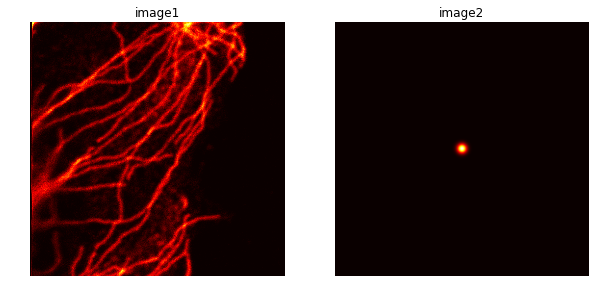

In [4]:
showim.display_2d_images(image, psf)

Run deconvolution

In [5]:
from supertomo.ui import deconvolution_options as options
n_iterations = 10
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [6]:
writer = imwrap.TiffImageWriter(data_dir)

task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

The original image size is (500, 500)
The deconvolution will be run with 1 blocks
The internal block size is (500, 500)
Preparing image fusion.
Beginning the computation of the 0. estimate
[===>             1/10                 ] E/S/U/N=0/977207/1569148/0, LEAK=-1.82873494126e-08%, TAU1=0.077331610024, TIME=0.125s, U/ESU=0.616 

/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Beginning the computation of the 1. estimate
[=======>         2/10                 ] ETA:906ms E/S/U/N=0/1586953/959402/0, LEAK=4.983813362e-09%, TAU1=0.0467792488635, TIME=0.108s, U/ESU=0.377 
Beginning the computation of the 2. estimate
[==========>      3/10                 ] ETA:802ms E/S/U/N=0/2039755/506600/0, LEAK=-2.02290406648e-08%, TAU1=0.0338498055935, TIME=0.111s, U/ESU=0.199 
Beginning the computation of the 3. estimate
[==============>  4/10                 ] ETA:673ms E/S/U/N=0/2267669/278686/0, LEAK=-4.39892566817e-09%, TAU1=0.0265790782869, TIME=0.103s, U/ESU=0.109 
Beginning the computation of the 4. estimate
[=================5/10                 ] ETA:552ms E/S/U/N=7/2363449/182899/0, LEAK=8.18399792379e-09%, TAU1=0.0218890607357, TIME=9.75E-2s, U/ESU=7.18E-2 
Beginning the computation of the 5. estimate
[=================6/10=>               ] ETA:438ms E/S/U/N=0/2420188/126167/0, LEAK=6.78797018594e-09%, TAU1=0.0186030436307, TIME=0.101s, U/ESU=4.95E-2 
Beginnin

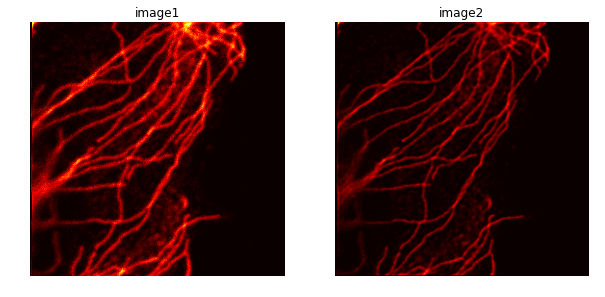

In [7]:
result = task.get_8bit_result()

showim.display_2d_images(image, result)



Show resolution curve

In [8]:
import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis



frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations-1):
    image1_name = "result_{}.tif".format(idx)
    image2_name = "result_{}.tif".format(idx+1)

    image1_path = os.path.join(data_dir, image1_name)
    image2_path = os.path.join(data_dir, image2_name)

    image1 = read.get_image(image1_path)
    image2 = read.get_image(image2_path)
    
    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0], args)
results = analyzer.execute()


Optimization terminated successfully.
         Current function value: 0.711120
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.687923
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.705450
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.711327
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.677799
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.694706
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.603540
         Iterations: 17
         Function evaluations: 34
Optimization terminated successful

/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poo

# Results

It is evident that this idea did not work. The two images are in practice equal, in terms of FRC analysis. 

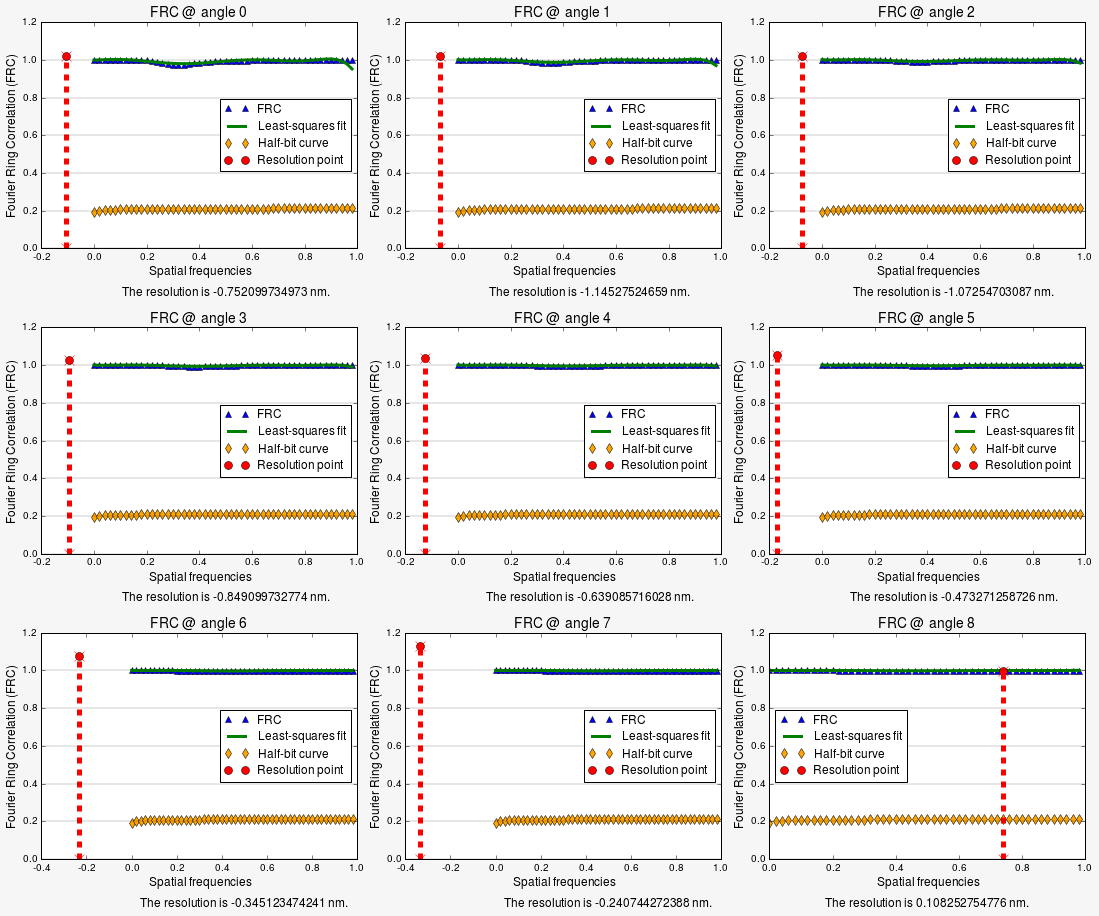

In [9]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()